# TinyTimeMixer (TTM) using single dataset - Exchange_rate



In [1]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

## Imports

In [2]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/Users/shivanitomar/Documents/Implementations/ps_pgsm_shapelets/incremental_code")
import utils

In [3]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Helper functions

In [4]:
# function for comparing the predicted values with actual values at a particular point in time (For ex: At 12/24/48 hrs from current time...)

def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):

  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

def construct_output_df(data, model_trainer):

    preds = model_trainer.predict(data)
    
    output_dict = {
        "date": [],
        "actual": [],
        "pred" : [],
        "context": [],
        "full_window": [],
    }      

    for i in range(len(data)):
        ts = data[i]["timestamp"]
        fv = data[i]["future_values"].numpy().flatten()
        pv = data[i]["past_values"].numpy().flatten()
        w = np.concatenate([pv, fv])

        output_dict["date"].append(ts)
        output_dict["actual"].append(list(fv))
        output_dict["context"].append(list(pv))
        output_dict["full_window"].append(list(w))

    # extracting zero shot predictions on val/test data
    for i in range(len(preds.predictions[0])):
        pred = preds.predictions[0][i].flatten()
        output_dict["pred"].append(list(pred))

    output_df = pd.DataFrame({
        "date": output_dict["date"],
        "prediction": output_dict["pred"],
        "actual": output_dict["actual"],
        "context": output_dict["context"],
        "full_window" : output_dict["full_window"],
    })
    return output_df

def plot_high_error_samples(rows, cols, df, error_threshold):

    indices = df.index[df["error"] > error_threshold].tolist()
    rand_indices = np.random.choice(indices, size=rows*cols, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for j, idx in enumerate(rand_indices):
        plot_df = pd.DataFrame({
            "pred": df.iloc[idx]['prediction'],
            "actual": df.iloc[idx]['actual']
        })
        axes[j].plot(plot_df)
        axes[j].set_title(f"Index {idx}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def load_shapelet(base_path, dataset):

    file_path = os.path.join(base_path, f'{dataset}.pkl')
    with open(file_path, 'rb') as handle:
        a_dict = pickle.load(handle)
    
    return(pd.DataFrame(a_dict.values()).transpose())

def get_top_k_timestamps_per_cluster(df, k=3, ascending=False):

    results = {}
    results_list = []
    for cluster_id in df["cluster"].unique():
        subset = df[df["cluster"] == cluster_id]
        if ascending:
            top_k = subset.nsmallest(k, "distance")
        else:
            top_k = subset.nlargest(k, "distance")
        results[cluster_id] = top_k["timestamp"].tolist()
        results_list.extend(top_k["timestamp"].tolist())
    return results, results_list

def dual_plots(dataset, trainer, data_split, model_type):
    

    df = construct_output_df(dataset, trainer)
    df["error"] = df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)

    preds = compare_forecast(df, "date", "prediction", "actual", 24)

    ax_comparison_plot = preds.plot(x="date", y=["actual", "pred"], figsize=(20,5), title=f"Comparing predictions v/s actual using {model_type} model on {data_split} SET", style=["-", "--"],              # solid for actual, dashed for pred
    color=["red", "blue"])
    ax_err_plot = df.plot(x="date", y=["error"], figsize=(25, 5), title=f"Error per sample on the {data_split} set using {model_type} model")
    ax_err_plot.axhline(y=df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {df['error'].mean():.3f}")
    ax_err_plot.legend(["Mean Squared Error"], loc="upper right", fontsize=12)
    
    if PLOT_DIR is not None:
        plot_file3 = f"{data_split}_{model_type}.pdf"
        plot_file4 = f"{data_split}_error_{model_type}.pdf"
        os.makedirs(PLOT_DIR, exist_ok=True)
        fig3 = ax_comparison_plot.get_figure()
        fig3.savefig(os.path.join(PLOT_DIR, plot_file3))

        fig4 = ax_err_plot.get_figure()
        fig4.savefig(os.path.join(PLOT_DIR, plot_file4))


def plot_shapelet_dict(shapelet_dict, cols):
    n_shapelets = len(shapelet_dict)
    rows = math.ceil(n_shapelets / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axs = axs.flatten()

    for i, (shapelet_id, shapelet) in enumerate(shapelet_dict.items()):
        axs[i].plot(shapelet, color='blue')
        axs[i].set_title(f"{shapelet_id}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")

    plt.tight_layout()
    plt.show()



### Distribution Analysis (To identify and quantify distribution shift between data splits)

5311 758 1519


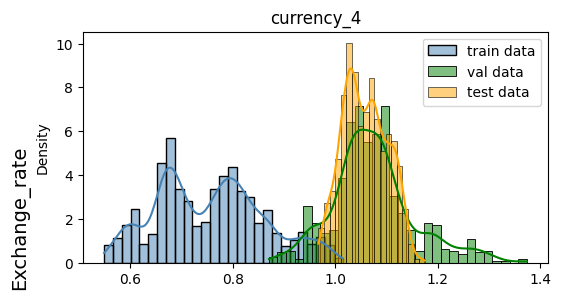

In [5]:
dataset_path = "/Users/shivanitomar/Documents/Implementations/SD_forger/FMforTS/data/monash_exchange_rate.csv"
timestamp_column = "timestamp"

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

# columns_to_drop = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
# data = data.drop(columns=columns_to_drop)

train_end = int(0.7*len(data))
val_end = train_end + int(0.1*len(data)) 


train_data = data[:train_end]
val_data = data[train_end : val_end]
test_data = data[val_end:]
print(len(train_data), len(val_data), len(test_data))

col = "currency_4"

plt.figure(figsize=(6, 3))
sns.histplot(train_data[col], color='steelblue', kde=True,
             stat='density', alpha=0.5, label='train data')
sns.histplot(val_data[col], color='green', kde=True,
             stat='density', alpha=0.5, label='val data')
sns.histplot(test_data[col], color='orange', kde=True,
             stat='density', alpha=0.5, label='test data')
plt.legend()
plt.xlabel('')
plt.ylabel('Density')
plt.title(col)
plt.suptitle("Exchange_rate", fontsize=14, x=0.02, y=0.5, rotation=90)
# plt.tight_layout()
plt.show()

### Metrics to quantify the distribution shifts between train/val/test : KL Divergence and Wasserstein Distance


In [6]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance

col = "currency_4"

train_values = train_data[col]
val_values = val_data[col]
test_values = test_data[col]


# Define common histogram bins across all
bins = np.linspace(min(train_values.min(), val_values.min(), test_values.min()),
                   max(train_values.max(), val_values.max(), test_values.max()),
                   50)

# Compute normalized histograms (probability distributions)
train_hist, _ = np.histogram(train_values, bins=bins, density=True)
val_hist, _ = np.histogram(val_values, bins=bins, density=True)
test_hist, _ = np.histogram(test_values, bins=bins, density=True)

# Add small constant to avoid log(0)
eps = 1e-10
train_hist += eps
val_hist += eps
test_hist += eps

# --- KL Divergence (asymmetrical) ---
kl_train_val = entropy(train_hist, val_hist)
kl_train_test = entropy(train_hist, test_hist)
kl_val_test = entropy(val_hist, test_hist)

# --- Wasserstein (Earth Mover’s) Distance ---
wd_train_val = wasserstein_distance(train_values, val_values)
wd_train_test = wasserstein_distance(train_values, test_values)
wd_val_test = wasserstein_distance(val_values, test_values)

print(f"KL(train‖val): {kl_train_val:.4f}")
print(f"KL(train‖test): {kl_train_test:.4f}")
print(f"KL(val‖test): {kl_val_test:.4f}\n")

print(f"Wasserstein(train, val): {wd_train_val:.4f}")
print(f"Wasserstein(train, test): {wd_train_test:.4f}")
print(f"Wasserstein(val, test): {wd_val_test:.4f}")


KL(train‖val): 20.7320
KL(train‖test): 22.9627
KL(val‖test): 3.8077

Wasserstein(train, val): 0.3178
Wasserstein(train, test): 0.3021
Wasserstein(val, test): 0.0270


### Data preparation and setting seeds 

In [9]:
# Set seed for reproducibility
seeds = [88]
# seeds = [44, 88, 22]
# SEED = 88, 11

# set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64
timestamp_column = "timestamp"
TARGET_DATASET = "exchange_rate"
dataset_path = "/Users/shivanitomar/Documents/Implementations/SD_forger/FMforTS/data/monash_exchange_rate.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"


# columns
id_columns = []
target_columns = ['currency_4']
split_config = {
    "train": 0.7, 
    "test": 0.2
}
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}
tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config
    )
print("Length of train/val/test", len(dset_train), len(dset_valid), len(dset_test))

Length of train/val/test 4704 665 1422


### Running pipeline with following steps:
- Zeroshot predictions on Validation set
- Extracting high error validation samples using Error threshold
- learning shapelets using the smaller validation set
- 

INFO:p-39579:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


************************************************************************************************************************
Running experiments for seed: 88


INFO:p-39579:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-39579:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ VALIDATION MSE zero-shot ++++++++++++++++++++


zeroshot output returned from evaluate() function {'eval_loss': 0.4505707025527954, 'eval_model_preparation_time': 0.001, 'eval_runtime': 0.5299, 'eval_samples_per_second': 1254.937, 'eval_steps_per_second': 20.758}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Average error on validation set : 0.45057067563142056
Error threshold for selecting validation samples for shapelet learning : 1.676390335429121


Number of validation samples used for learning shapelet dictionary:  29
setting random seed to 88 for dictionary initialization
Converged!
Allowed % of predictions that can be discarded : 0.2
Allowed number of samples to be discarded : 284
test_distances calculated 


discarding loop complete


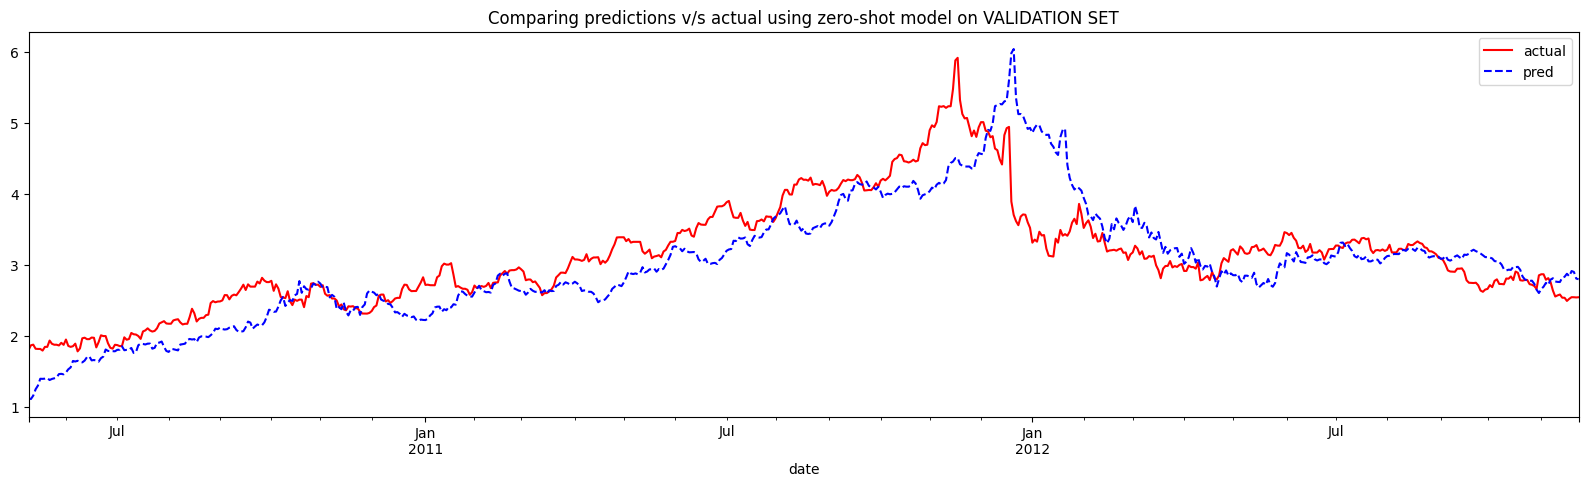

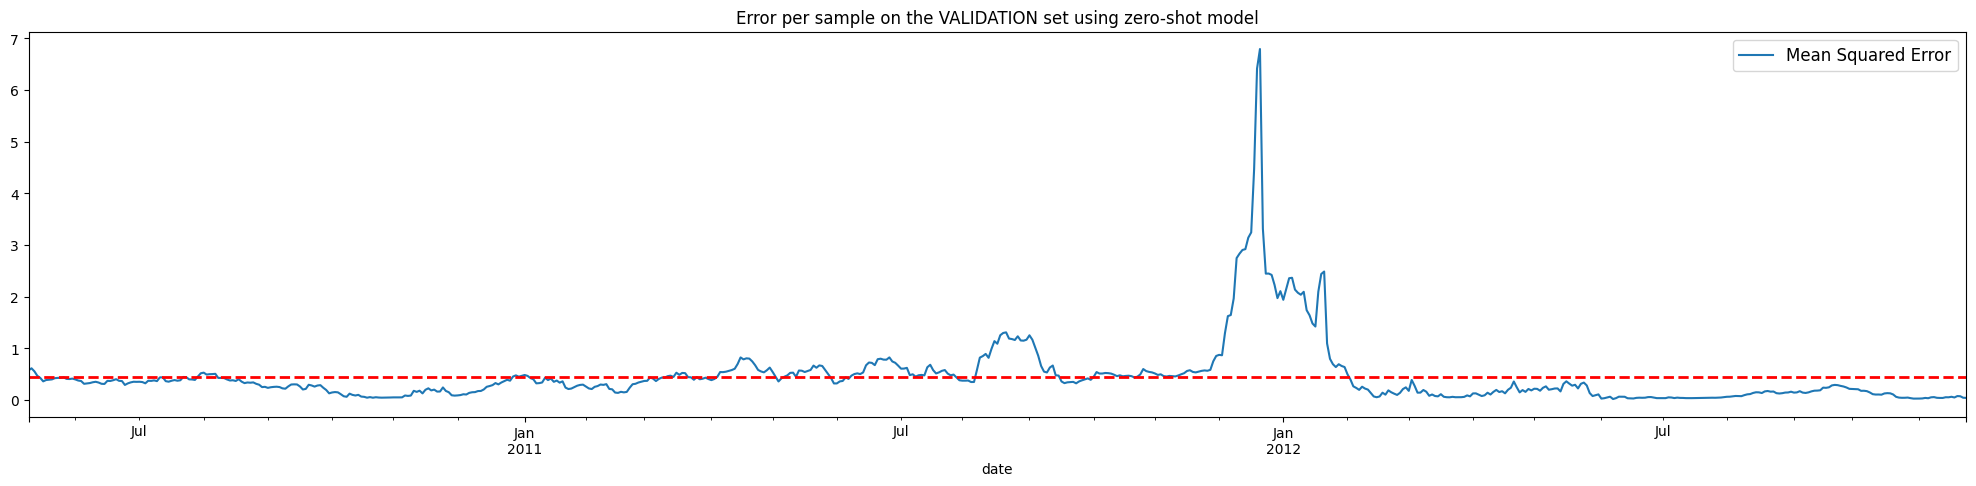

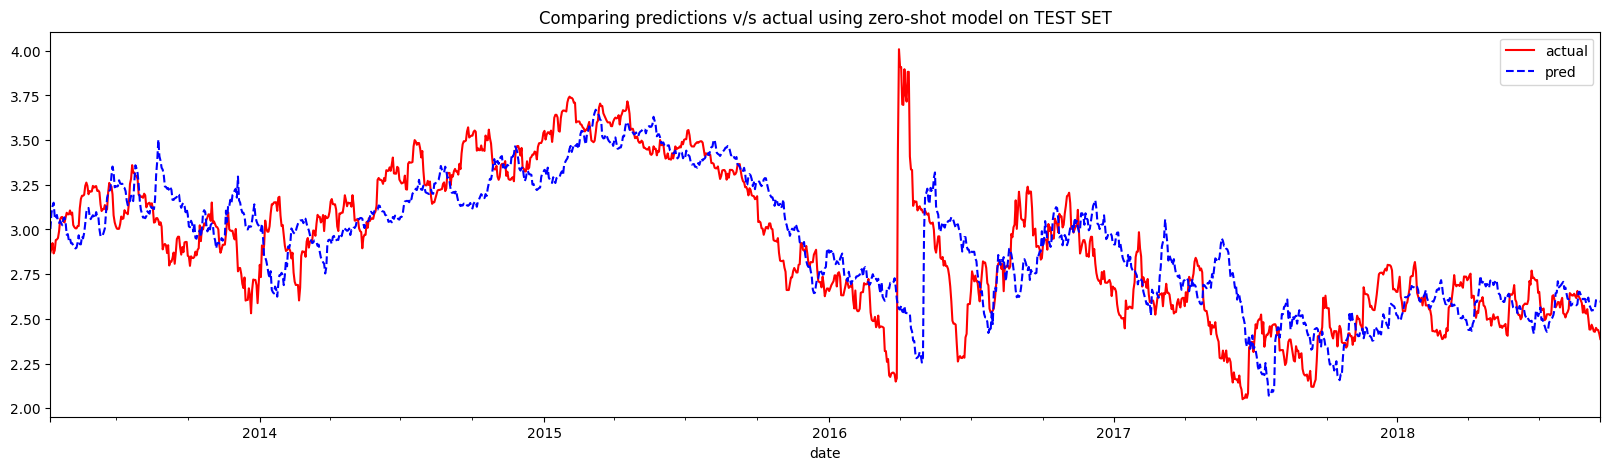

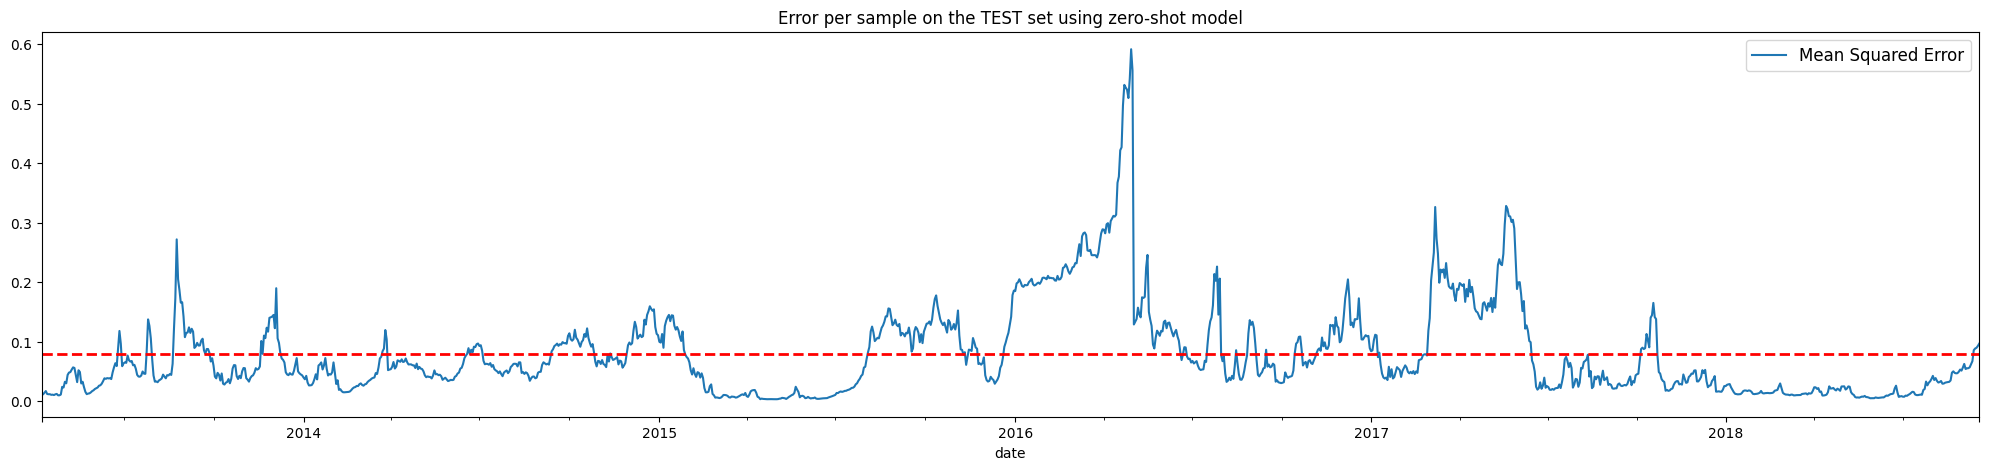

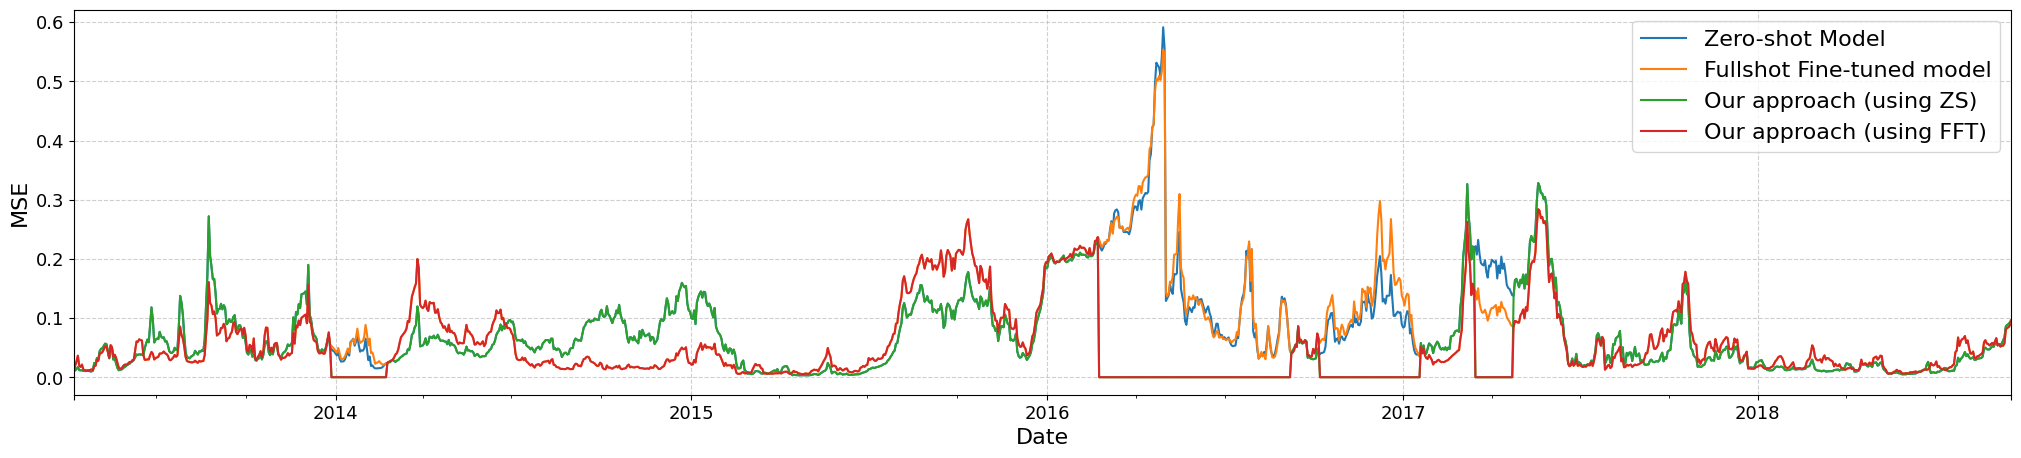

In [10]:
results = []
results_df_dir = f"results/{TARGET_DATASET}"
for SEED in seeds:
    
    print("*" * 120)
    print(f"Running experiments for seed:", SEED)

    RES_DIR = f"results/{TARGET_DATASET}/seed_{SEED}"
    PLOT_DIR = f"plots/{TARGET_DATASET}/seed_{SEED}"
    

    # zero-shot model 
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        prediction_channel_indices=tsp.prediction_channel_indices,
        num_input_channels=tsp.num_input_channels
    )
    
    temp_dir = tempfile.mkdtemp()
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=BATCH_SIZE,
            seed=SEED,
            report_to="none",
        ),
    )
    print("+" * 20, "VALIDATION MSE zero-shot", "+" * 20)
    val_zeroshot_output = zeroshot_trainer.evaluate(dset_valid)
    print("zeroshot output returned from evaluate() function", val_zeroshot_output)

    # extract high error val samples using error threshold
    zs_val_df = construct_output_df(dset_valid, zeroshot_trainer)
    zs_val_df["error"] = zs_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)

    mean_error = np.mean(zs_val_df["error"])
    std_error = np.std(zs_val_df["error"])
    err_threshold = mean_error + (2 * std_error)
    print("+" * 60)
    print("Average error on validation set :", mean_error)
    print("Error threshold for selecting validation samples for shapelet learning :", err_threshold)
  
    high_error_val_samples = zs_val_df[zs_val_df["error"] > err_threshold]
    # high_error_val_samples

    dual_plots(dataset=dset_valid, trainer=zeroshot_trainer, data_split="VALIDATION", model_type="zero-shot")


    # loading the fine-tuned model
    fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/AAAI2026/ttm_finetuned_models/exchange_rate/v1_fft/checkpoint-2499")
    temp_dir = tempfile.mkdtemp()

    fft_trainer = Trainer(
            model=fft_model,
            args=TrainingArguments(
                output_dir=temp_dir,
                per_device_eval_batch_size=64,
                seed=SEED,
                report_to="none",
            ),
        )
    fft_test_df = construct_output_df(dset_test, fft_trainer)
    fft_test_df["error"] = fft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)


    # shapelet learning based on selected validation set
    
    context_array = np.array(high_error_val_samples["context"].tolist())
    n, p = context_array.shape
    print("Number of validation samples used for learning shapelet dictionary: ", n)
    r = 0.2 
    q = int(np.ceil(p * r))
    k = 50
    S, A, Offsets, F_obj = utils.USIDL_with_alpha_const(context_array, lambda_=0.1, K=k, q=q, c=100, epsilon=1e-5,
                                        maxIter=2e3, maxInnerIter=5, random_seed=SEED)
    shapelet_dict = {f'shapelet_{i}': S[i] for i in range(S.shape[0])}

    # saving all the shapelets in a pickle file
    filename = "all_shapelets.pkl"
    os.makedirs(RES_DIR, exist_ok=True)
    base_path = os.path.join(RES_DIR, filename)
    with open(base_path, 'wb') as f:
        pickle.dump(shapelet_dict, f)
    

    #rank shapelets based on alpha coeff to eliminate redundancy
    alpha_df = pd.DataFrame(A)
    k=25

    alpha_sum = alpha_df.sum(axis=0).to_frame().T
    topk_shap_idx = alpha_sum.iloc[0].nlargest(k).index
    df_top25 = alpha_sum[topk_shap_idx]

    select_shapelets = {}
    for key, value in shapelet_dict.items():
        idx = int(key.split("_")[1])
        if idx in topk_shap_idx:
            select_shapelets[key] = value

    # saving topK shapelets in a pickle file
    filename = "topK_shapelets.pkl"
    os.makedirs(RES_DIR, exist_ok=True)
    base_path = os.path.join(RES_DIR, filename)
    with open(base_path, 'wb') as f:
        pickle.dump(select_shapelets, f)

    def z_norm(x):
        return (x - np.mean(x)) / np.std(x)

    def shapelet_distance(segment, series):
        seg = z_norm(segment)
        series = z_norm(series)
        seg_len = len(seg)
        return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))

    # User defined drop percentage to discard the number of predictions leading to high error
    percent = 0.2
    drop_limit = int(percent * len(dset_test))
    print("Allowed % of predictions that can be discarded :", percent)
    print("Allowed number of samples to be discarded :", drop_limit)

    test_distances_ed = np.zeros((len(dset_test),len(select_shapelets)))
    

    # save all the test distances with shapelets in an array
    for i in range(len(dset_test)):
        for j, shapelet in enumerate(select_shapelets.values()):
            series = np.array(dset_test[i]["past_values"].squeeze(1))
            dist = shapelet_distance(shapelet, series)
            test_distances_ed[i, j] = dist
    
    print("test_distances calculated ")

    # import warnings
    # distance 
    min_dists = test_distances_ed.min(axis=1)
    sorted_idx = np.argsort(min_dists)
    samples_to_drop = sorted_idx[:drop_limit]

    total_error_zs = []
    total_error_fft = []

    for i in range(len(dset_test)):
        if i in samples_to_drop:
            # print("Discarding the sample due to high similarity with one of the shapelets")
            dis = 0
            total_error_zs.append(dis)
            total_error_fft.append(dis)

        else:
            # with warnings.catch_warnings():
            #     warnings.simplefilter("ignore")

            # using zs model to predict the remaining test samples
            zs_preds_dict = zeroshot_trainer.predict([dset_test[i]])
            zs_preds = zs_preds_dict.predictions[0]
            zs_preds = zs_preds.squeeze(0)
            actual = np.array(dset_test[i]["future_values"])
            zs_error = mean_squared_error(zs_preds, actual)
            total_error_zs.append(zs_error)

            # using the fft model to predict the remaining test samples
            fft_preds_dict = fft_trainer.predict([dset_test[i]])
            fft_preds = fft_preds_dict.predictions[0]
            fft_preds = fft_preds.squeeze(0)
            fft_error = mean_squared_error(fft_preds, actual)
            total_error_fft.append(fft_error)

    print("discarding loop complete")

    # Error after discarding allowed unreliable predictions
    # print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))
    discard_df = pd.DataFrame(total_error_zs, columns=["zs_error"])

    
    discard_df["fft_error"] = total_error_fft



# plotting the same two plots for test set

    dual_plots(dataset=dset_test, trainer=zeroshot_trainer, data_split="TEST", model_type="zero-shot")

    zs_test_df = construct_output_df(dset_test, zeroshot_trainer)
    zs_test_df["error"] = zs_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
    discard_df['date'] = zs_test_df["date"]

    
    # plotting 2 cases : 1. plot showing discarded close matching samples and using ZS model for remaining predictions.
    #                    2. plot showing discarded close matching samples and using FT model for remaining predictions.


    ax_final = zs_test_df.plot(
        x="date",
        y="error",
        figsize=(25, 5),     
        label="Zero-shot Model",
        # title="MSE per sample on the test set using zero-shot model, fine-tuned and post discarding unreliable predictions"
    )

    fft_test_df.plot(
        x="date",
        y="error",
        ax=ax_final,
        label="Fullshot Fine-tuned model"

    )


    discard_df.plot(
        x="date",
        y="zs_error",
        ax=ax_final,
        label="Our approach (using ZS)"

    )

    discard_df.plot(
        x="date",
        y="fft_error",
        ax=ax_final,
        label="Our approach (using FFT)"

    )
    # --- Formatting plots ---
    ax_final.set_xlabel("Date", fontsize=16)
    ax_final.set_ylabel("MSE", fontsize=16)
    # ax_final.set_title(
    #     "MSE per sample on the test set using zero-shot model, fine-tuned and post discarding unreliable predictions",
    #     fontsize=18,
    #     # pad=15  # adds a little vertical space above title
    # )
    ax_final.legend(fontsize=16)
    ax_final.tick_params(axis='both', labelsize=13)
    ax_final.grid(True, linestyle='--', alpha=0.6)

    # plt.tight_layout()
    # plt.show()


    if PLOT_DIR is not None:
        plot_final = "final_comparison_plot.pdf"
        os.makedirs(PLOT_DIR, exist_ok=True)
        fig_final = ax_final.get_figure()
        fig_final.savefig(os.path.join(PLOT_DIR, plot_final))
    
    # Store results
    results.append({
        "seed": SEED,
        "zs_error": np.mean(zs_test_df["error"]),
        "fft_error": np.mean(fft_test_df["error"]),
        "discard_using_zs": np.mean(discard_df["zs_error"]),
        "discard_using_fft": np.mean(discard_df["fft_error"])
        # "discard_using_random"
    })

# results_df = pd.DataFrame(results)
# results_filename = "results_all_seeds.csv"
# os.makedirs(results_df_dir, exist_ok=True)
# results_path = os.path.join(results_df_dir, results_filename)
# results_df.to_csv(results_path, index=False)
# print(f"Results saved to: {results_path}")

 ## Few-shot finetune and evaluation method

In [13]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("+" * 20, "TSP values", "+" * 20)
    print(tsp.prediction_channel_indices)
    print(tsp.exogenous_channel_indices)
    print(tsp.context_length)
    print(tsp.prediction_length)
    print(tsp.num_input_channels)
    print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            head_dropout=0.7,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    )
    print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v1_fft"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

### Fine-tuning on full dataset (using 100% train split)

INFO:p-54877:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------
++++++++++++++++++++ TSP values ++++++++++++++++++++
[0]
[]
512
96
1
standard


INFO:p-54877:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-54877:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 4704
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.0001


Epoch,Training Loss,Validation Loss
1,0.185800,0.450031
2,0.194800,0.449909
3,0.154900,0.452434
4,0.143400,0.452949
5,0.137900,0.448558
6,0.132900,0.440943
7,0.129600,0.436787
8,0.126500,0.434742
9,0.123600,0.429364
10,0.123300,0.426252


[TrackingCallback] Mean Epoch Time = 62.08960030078888 seconds, Total Train Time = 2429.389011144638
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.0776323676109314, 'eval_runtime': 60.3016, 'eval_samples_per_second': 23.581, 'eval_steps_per_second': 0.746, 'epoch': 20.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
prediction metrics on test set {'test_loss': 0.0776323676109314, 'test_runtime': 60.9823, 'test_samples_per_second': 23.318, 'test_steps_per_second': 0.738}
(1422, 96, 1)
(1422, 1, 8, 192)


PredictionOutput(predictions=(array([[[3.0063007],
        [3.0120745],
        [3.000702 ],
        ...,
        [3.1605597],
        [3.1576009],
        [3.1484976]],

       [[3.0939813],
        [3.0882325],
        [3.0722895],
        ...,
        [3.2439594],
        [3.2510214],
        [3.244109 ]],

       [[3.131203 ],
        [3.1188505],
        [3.1101904],
        ...,
        [3.274762 ],
        [3.2864702],
        [3.280191 ]],

       ...,

       [[2.6404452],
        [2.638773 ],
        [2.636233 ],
        ...,
        [2.5273845],
        [2.5318131],
        [2.5334141]],

       [[2.6431913],
        [2.6440344],
        [2.6370203],
        ...,
        [2.5308833],
        [2.537018 ],
        [2.5381653]],

       [[2.6493478],
        [2.6458693],
        [2.6413345],
        ...,
        [2.547154 ],
        [2.5500648],
        [2.5508046]]], dtype=float32), array([[[[-0.01767771, -0.12785909,  0.07375843, ...,  0.03067425,
          -0.05611922, -0.21

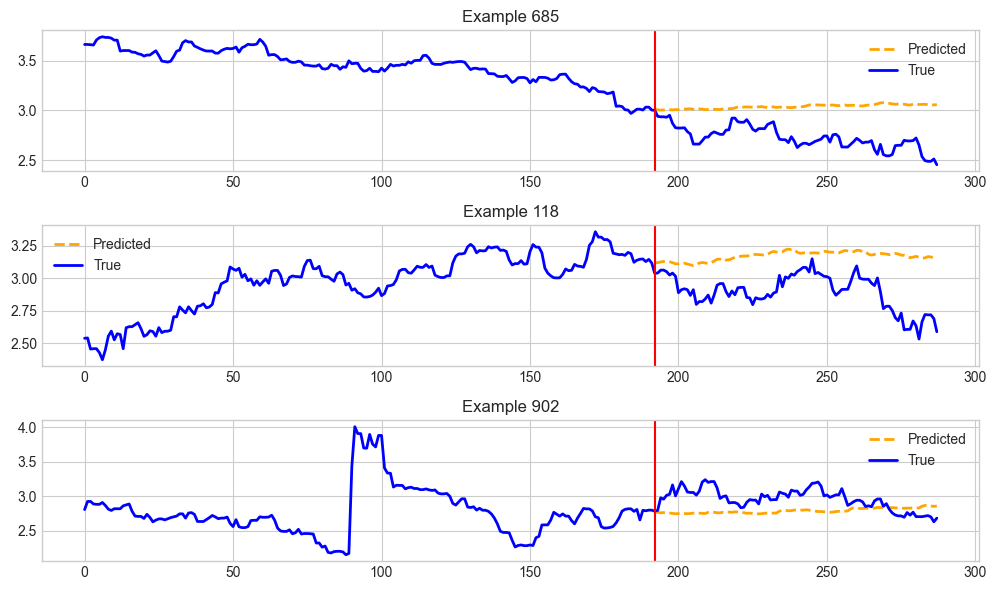

In [15]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=32,
    fewshot_percent=100,
    learning_rate=0.0001,
    num_epochs=20,
)

In [ ]:
fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/AAAI2026/ttm_finetuned_models/exchange_rate/v1_fft/checkpoint-518")
temp_dir = tempfile.mkdtemp()

fft_trainer = Trainer(
        model=fft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )
fft_test_df = construct_output_df(dset_test, fft_trainer)

### Results discussion for the paper

In [11]:
# Loading the shapelets for exchange rate and comparing the matching test context to add the discussion in the paper

file_path = "/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/AAAI2026/results/exchange_rate/seed_88/topK_shapelets.pkl"
with open(file_path, 'rb') as handle:
    a_dict = pickle.load(handle)
    
# topk_shap = pd.DataFrame(a_dict.values())

def z_norm(x):
        return (x - np.mean(x)) / np.std(x)

def shapelet_distance(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)
    return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))


for i in range(len(dset_test)):
    for j, (key, value) in enumerate(a_dict.items()):
        # print(key)
        series = np.array(dset_test[i]["past_values"].squeeze(1))
        dist = shapelet_distance(value, series)
        test_distances_ed[i, j] = dist



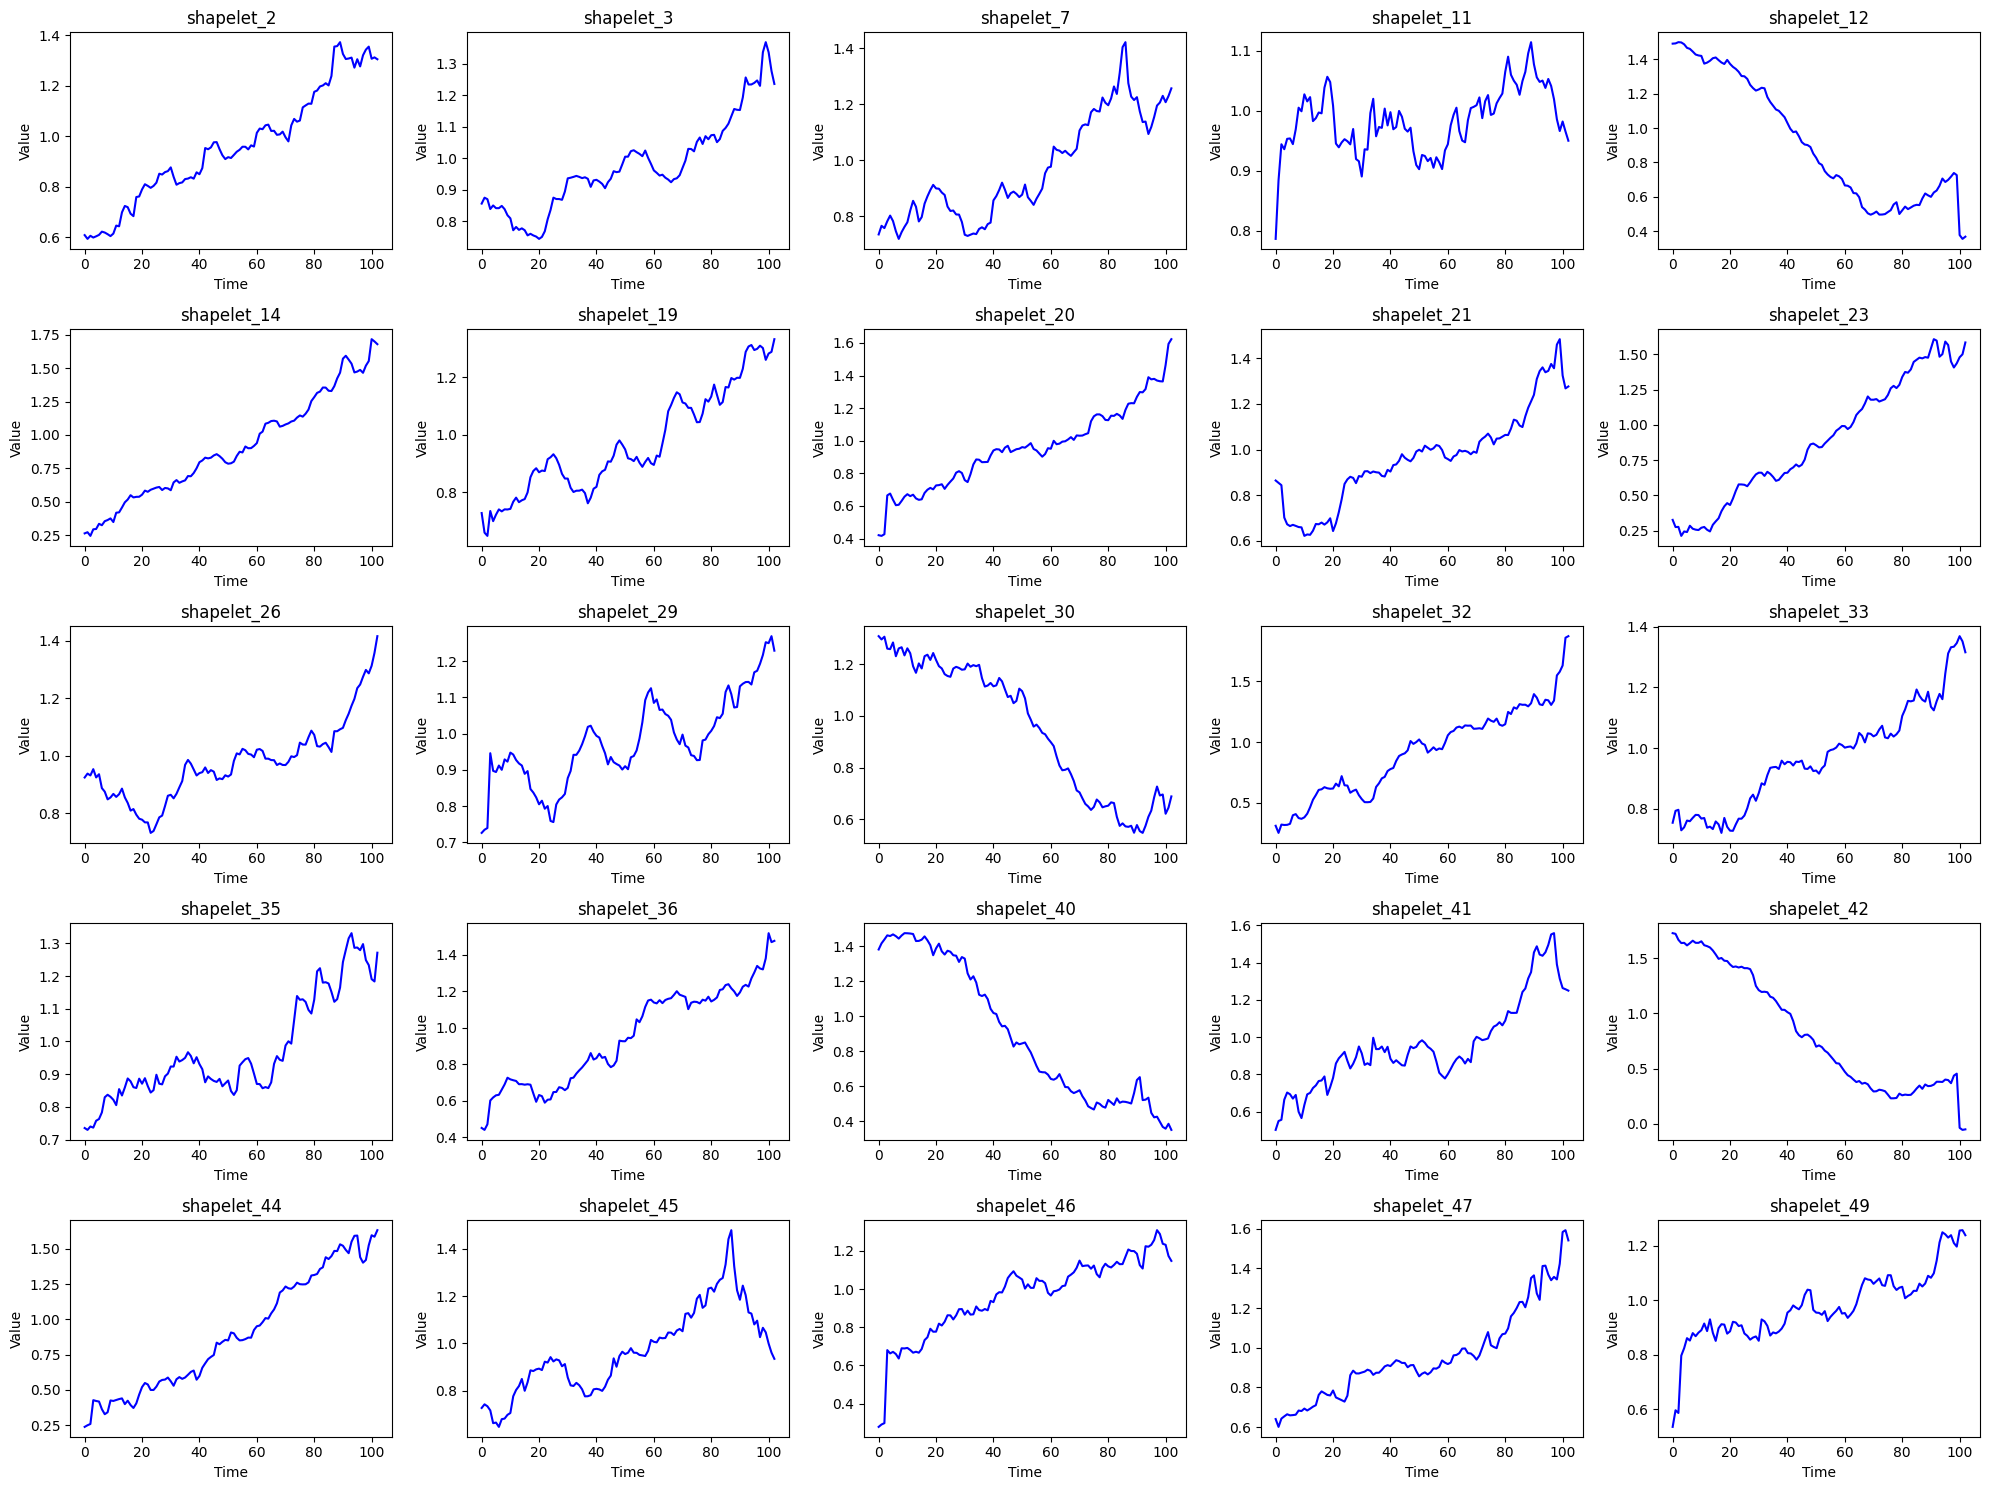

In [12]:
plot_shapelet_dict(a_dict, 5)

In [13]:
min_dists = test_distances_ed.min(axis=1)
shap_indices = np.argmin(test_distances_ed, axis=1)

mapping_df = pd.DataFrame({"min_distance": min_dists,
                            "closest_shap_idx": shap_indices,
                            "sample_idx": range(len(min_dists))
                            })
sorted_idx = np.argsort(min_dists)
samples_to_drop = sorted_idx[:drop_limit]

# sort the mapping df based on min_distances
sorted_df = mapping_df.sort_values(by='min_distance', ascending=True)
top_k_df = sorted_df.head(drop_limit)
top_k_df


,min_distance,closest_shap_idx,sample_idx
195,4.006296,12,195
196,4.007976,12,196
197,4.010786,12,197
198,4.013280,12,198
200,4.013789,12,200
...,...,...,...
914,4.447129,12,914
1028,4.448664,17,1028
891,4.449357,12,891
987,4.449986,12,987


In [17]:
shapelet_mapping_df = pd.DataFrame({"key": a_dict.keys(),
                            "shapelet_idx": range(len(a_dict))
                            })
shapelet_mapping_df

,key,shapelet_idx
0,shapelet_2,0
1,shapelet_3,1
2,shapelet_7,2
3,shapelet_11,3
4,shapelet_12,4
5,shapelet_14,5
6,shapelet_19,6
7,shapelet_20,7
8,shapelet_21,8
9,shapelet_23,9


In [15]:
def shapelet_distance_w_idx(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)

    min_dist = float('inf')
    min_idx = -1

    # Slide the segment across the series
    for i in range(len(series) - seg_len + 1):
        dist = np.linalg.norm(seg - series[i:i+seg_len])
        if dist < min_dist:
            min_dist = dist
            min_idx = i

    return min_dist, min_idx

closest matching shapelet key is  shapelet_40
min distance is 4.44866418838501 and matching offset is 116


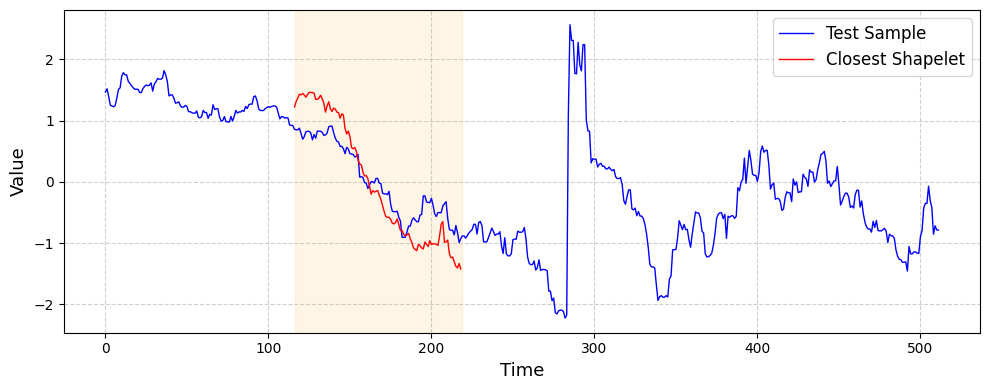

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# one test sample and its closest shapelet
sample = np.array(dset_test[1028]["past_values"].squeeze(1))   
shap_key = shapelet_mapping_df[shapelet_mapping_df["shapelet_idx"] == 17]['key'].iloc[0] 
print("closest matching shapelet key is ", shap_key)
shapelet = a_dict[shap_key]
min_dist, start_idx = shapelet_distance_w_idx(shapelet, sample)
print(f"min distance is {min_dist} and matching offset is {start_idx}")
end_idx = start_idx + len(shapelet)

sample_scaled = z_norm(sample)
shapelet_scaled = z_norm(shapelet)
# Create x-axis for time
x_sample = np.arange(len(sample))
x_shapelet = np.arange(start_idx, end_idx)

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(x_sample, sample_scaled, label="Test Sample", color='blue', linewidth=1, alpha=1)
plt.plot(x_shapelet, shapelet_scaled, label="Closest Shapelet", color='red', linewidth=1)

# Highlight the matched region
plt.axvspan(start_idx, end_idx, color='orange', alpha=0.1)

plt.xlabel("Time", fontsize=13)
plt.ylabel("Value", fontsize=13)
# plt.title("Sample and Closest Shapelet (Aligned)", fontsize=15, pad=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


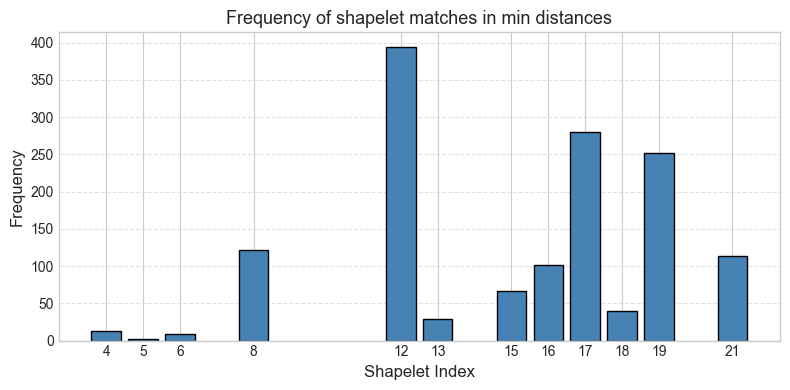

In [116]:
unique, counts = np.unique(shap_indices, return_counts=True)

plt.figure(figsize=(8, 4))
plt.bar(unique, counts, color='steelblue', edgecolor='black')

plt.xlabel('Shapelet Index', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of shapelet matches in min distances', fontsize=13)
plt.xticks(unique)  # ensure all integer indices appear on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()